# Two Layer QG Model Example #

Here is a quick overview of how to use the two-layer model. See the
:py:class:`pyqg.QGModel` api documentation for further details.

First import numpy, matplotlib, and pyqg:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pyqg
from pyqg import diagnostic_tools as tools

## Initialize and Run the Model ##

Here we set up a model which will run for 10 years and start averaging
after 5 years. There are lots of parameters that can be specified as
keyword arguments but we are just using the defaults.

In [87]:
# Number of points of the grid along both axes, for the LR
nb_points_LR=64

# Size of the domain
L = 1e6

# Ratio of low resolution by deformation radius
ratio_rez_rd = 1.3

# HR or LR
rez = 'LR'

# factor should probably not be changed
factor = 4

# Run time
year = 24*60*60*360.
tmax= 10 * year

# Mean zonal flows
U1 = 0.025
U2 = 0

In [88]:
rd = (L / nb_points_LR) / ratio_rez_rd
nb_points = nb_points_LR

In [89]:
def run_and_save(model, variable_names, snapint=5):
    day = 3600 * 24
    saved = {key: [] for key in variable_names}
    for snapshot in model.run_with_snapshots(tsnapint=snapint * day):
        for var in variable_names:
            saved[var].append(np.asarray(getattr(model, var).copy()))
    for var in saved.keys():
        saved[var] = np.stack(saved[var], axis=0)
    return saved

In [90]:
year = 24*60*60*360.
dt = 1800
m = pyqg.QGModel(tmax=tmax, twrite=10000, tavestart=tmax // 2, nx=nb_points, L=L, rd=rd, dt=dt,
                U1=U1, U2=U2, ntd=3)
sim_lr = run_and_save(m, ['u', 'v'])
m_h = pyqg.QGModel(tmax=tmax, twrite=10000, tavestart=tmax // 2, nx=nb_points * factor, L=L, rd=rd, dt=dt, 
                   U1=U1, U2=U2, ntd=3)
sim_hr = run_and_save(m_h, ['u', 'v'])


INFO:  Logger initialized
INFO: Step: 10000, Time: 1.80e+07, KE: 5.37e-06, CFL: 0.003
INFO: Step: 20000, Time: 3.60e+07, KE: 4.84e-04, CFL: 0.019
INFO: Step: 30000, Time: 5.40e+07, KE: 7.80e-04, CFL: 0.033
INFO: Step: 40000, Time: 7.20e+07, KE: 6.07e-04, CFL: 0.025
INFO: Step: 50000, Time: 9.00e+07, KE: 6.60e-04, CFL: 0.025
INFO: Step: 60000, Time: 1.08e+08, KE: 5.96e-04, CFL: 0.028
INFO: Step: 70000, Time: 1.26e+08, KE: 6.43e-04, CFL: 0.027
INFO: Step: 80000, Time: 1.44e+08, KE: 5.95e-04, CFL: 0.024
INFO: Step: 90000, Time: 1.62e+08, KE: 6.42e-04, CFL: 0.026
INFO: Step: 100000, Time: 1.80e+08, KE: 6.43e-04, CFL: 0.027
INFO: Step: 110000, Time: 1.98e+08, KE: 6.14e-04, CFL: 0.024
INFO: Step: 120000, Time: 2.16e+08, KE: 6.49e-04, CFL: 0.029
INFO: Step: 130000, Time: 2.34e+08, KE: 6.52e-04, CFL: 0.027
INFO: Step: 140000, Time: 2.52e+08, KE: 6.57e-04, CFL: 0.026
INFO: Step: 150000, Time: 2.70e+08, KE: 6.48e-04, CFL: 0.024
INFO: Step: 160000, Time: 2.88e+08, KE: 6.61e-04, CFL: 0.024
INFO: S

## Visualize Output ##


We access the actual pv values through the attribute ``m.q``. The first axis
of ``q`` corresponds with the layer number. (Remeber that in python, numbering
starts at 0.)

In [91]:
sim_hr['u'][-1, 0]

array([[-0.038558  , -0.04708284, -0.05959466, ..., -0.01762085,
        -0.02654613, -0.03300917],
       [-0.04513421, -0.05340702, -0.06189386, ..., -0.02471266,
        -0.03205972, -0.03801942],
       [-0.05078728, -0.05949208, -0.0635727 , ..., -0.02764253,
        -0.03438763, -0.04125101],
       ...,
       [-0.02014472, -0.03041221, -0.04475308, ...,  0.00403492,
        -0.00577175, -0.01330695],
       [-0.02661189, -0.03670123, -0.0506728 , ..., -0.00127935,
        -0.01192178, -0.02000233],
       [-0.0320248 , -0.04086737, -0.05380786, ..., -0.00828726,
        -0.01870555, -0.02639097]])

<IPython.core.display.Javascript object>


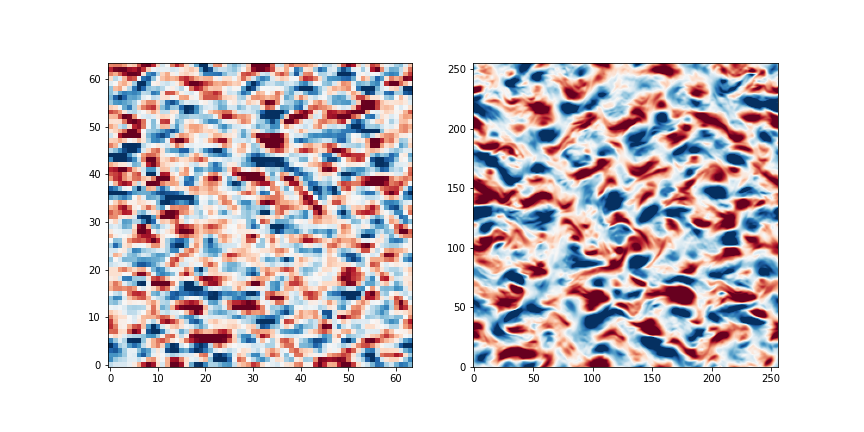

<ipython-input-93-9e162c2ca26b>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, n, i_sub + 1)


In [93]:
%matplotlib notebook
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter

def coarsen(data, factor: int = 4, axes=(-1, -2)):
    scales = [0] * data.ndim
    for i in axes:
        scales[i] = factor / 2.
    filtered = gaussian_filter(data, scales)
    result = np.zeros((data.shape[0:2]) + (data.shape[2] // factor,
                                           data.shape[3] // factor))
    for i in range(factor):
        for j in range(factor):
            result += filtered[..., i::factor, j::factor]
    return result / factor**2

def play_movies(sim: np.ndarray, title: str = '',
               interval: int = 500, vmin=None, vmax=None, cmap='ocean'):
    n = len(sim)
    nb = sim[0].shape[0]
    fig = plt.figure(figsize=(12, 6))
    ims = list()
    if vmin is None:
        mean = np.mean(sim)
        std = np.std(sim)
        vmin, vmax = mean - 2 * std, mean + 2 * std
    for i in range(nb):
        shows = []
        for i_sub in range(n):
            plt.subplot(1, n, i_sub + 1)
            im = sim[i_sub][i, ...]
            show = plt.imshow(im, vmin=vmin, vmax=vmax,
                               cmap=cmap,
                               origin='lower', animated=True)
            shows.append(show)
        ims.append(shows)
    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                    repeat_delay=1000)
    plt.title(title)
    plt.show()
    return ani

ani = play_movies([sim_lr['u'][-500:, 0], sim_hr['u'][-500:, 0]], vmin=-0.1, vmax=0.1, cmap='RdBu_r')

<IPython.core.display.Javascript object>


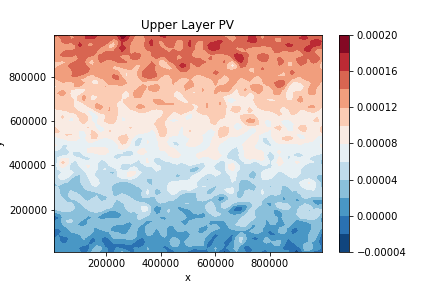

In [75]:
plt.figure()
q_upper = m.q[0] + m.Qy[0]*m.y
plt.contourf(m.x, m.y, q_upper, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer PV')
plt.colorbar();

<IPython.core.display.Javascript object>


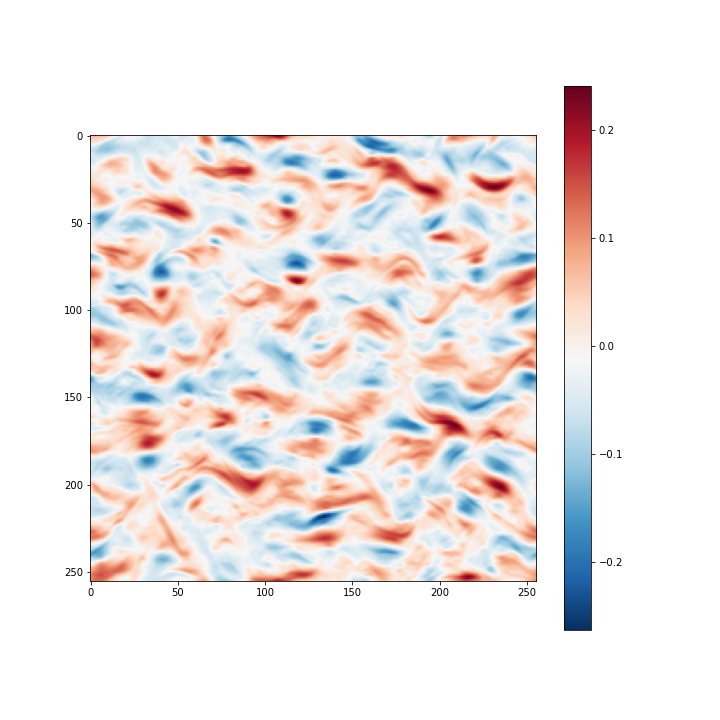

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(m_h.u[0], cmap='RdBu_r')
plt.colorbar()

## Plot Diagnostics ##

The model automatically accumulates averages of certain diagnostics. We can 
find out what diagnostics are available by calling

In [76]:
m.describe_diagnostics()

NAME               | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total APE generation                                  
APEgenspec | spectrum of APE generation                            
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                       
KEspec     |  kinetic energy spectrum                              
adv_param  | Spectral contribution of param                        
entspec    | barotropic enstrophy spectrum                         
q          | QGPV                                                  


To look at the wavenumber energy spectrum, we plot the `KEspec` diagnostic.
(Note that summing along the l-axis, as in this example, does not give us
a true *isotropic* wavenumber spectrum.)

<IPython.core.display.Javascript object>


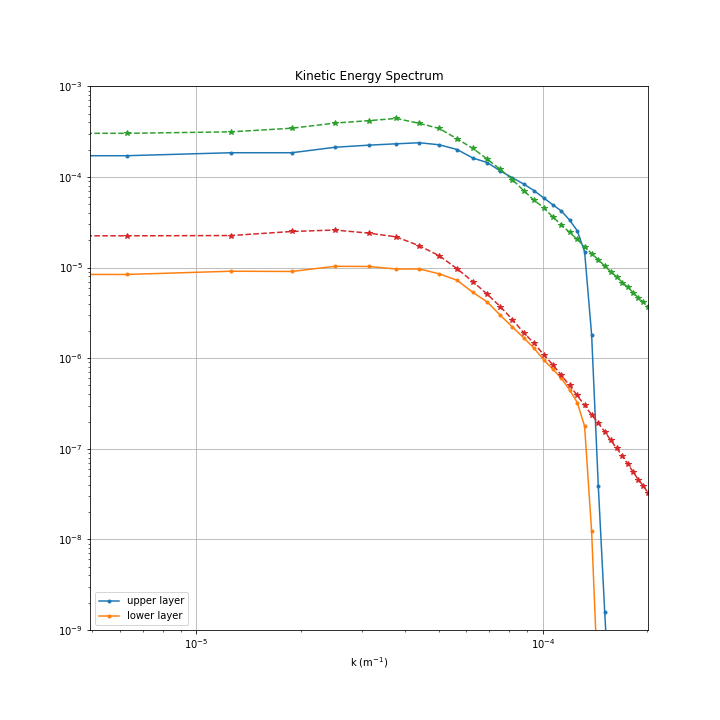

<ipython-input-77-444d3bf8f20d>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([1e-9,1e-3]); plt.xlim([m.kk.min(), m.kk.max()])


In [77]:
%matplotlib notebook
plt.figure(figsize=(10, 10))
kespec_u = m.get_diagnostic('KEspec')[0].sum(axis=0)
kespec_l = m.get_diagnostic('KEspec')[1].sum(axis=0)
plt.loglog( m.kk, kespec_u, '.-' )
plt.loglog( m.kk, kespec_l, '.-' )

kespec_u = m_h.get_diagnostic('KEspec')[0].sum(axis=0)
kespec_l = m_h.get_diagnostic('KEspec')[1].sum(axis=0)
plt.loglog( m_h.kk, kespec_u, '--*' )
plt.loglog( m_h.kk, kespec_l, '--*' )


plt.legend(['upper layer','lower layer'], loc='lower left')
plt.ylim([1e-9,1e-3]); plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum');

<IPython.core.display.Javascript object>


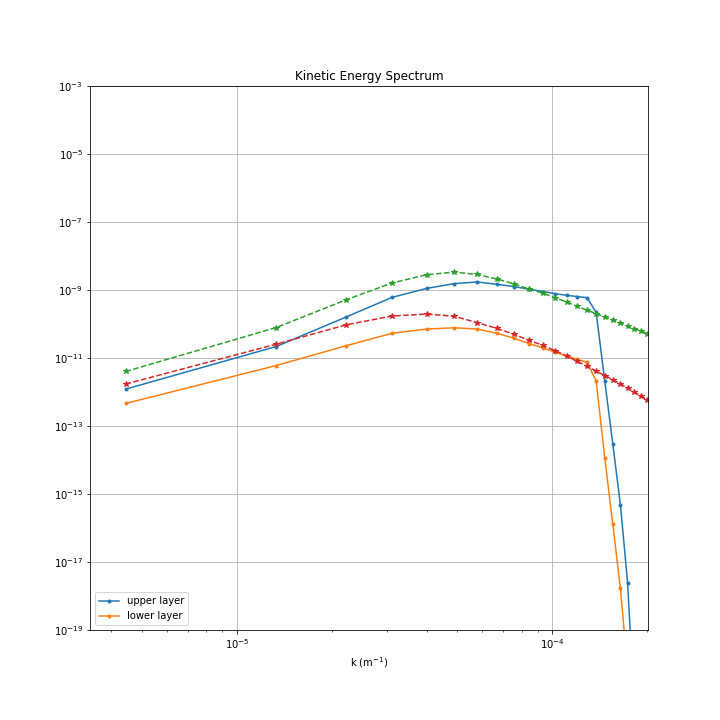

<ipython-input-78-cb55bc00f748>:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([1e-19,1e-3]); plt.xlim([m.kk.min(), m.kk.max()])


In [78]:
plt.figure(figsize=(10, 10))
k_radial, kespec_u = tools.calc_ispec(m, m.get_diagnostic('KEspec')[0])
_, kespec_l = tools.calc_ispec(m, m.get_diagnostic('KEspec')[1])
plt.loglog( k_radial, kespec_u, '.-' )
plt.loglog( k_radial, kespec_l, '.-' )

k_radial, kespec_u = tools.calc_ispec(m_h, m_h.get_diagnostic('KEspec')[0])
_, kespec_l = tools.calc_ispec(m_h, m_h.get_diagnostic('KEspec')[1])
plt.loglog( k_radial, kespec_u, '--*' )
plt.loglog( k_radial, kespec_l, '--*' )

plt.legend(['upper layer','lower layer'], loc='lower left')
plt.ylim([1e-19,1e-3]); plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum');

We can also plot the spectral fluxes of energy.

<IPython.core.display.Javascript object>


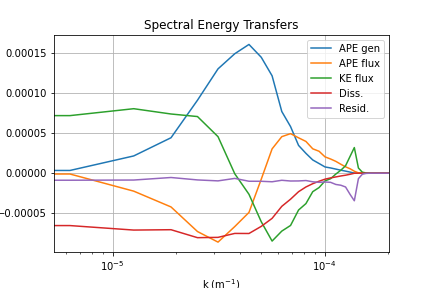

<ipython-input-79-591d4a456e18>:11: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([m.kk.min(), m.kk.max()])


In [79]:
plt.figure()

ebud = [ m.get_diagnostic('APEgenspec').sum(axis=0),
         m.get_diagnostic('APEflux').sum(axis=0),
         m.get_diagnostic('KEflux').sum(axis=0),
         -m.rek*m.del2*m.get_diagnostic('KEspec')[1].sum(axis=0)*m.M**2 ]
ebud.append(-np.vstack(ebud).sum(axis=0))
ebud_labels = ['APE gen','APE flux','KE flux','Diss.','Resid.']
[plt.semilogx(m.kk, term) for term in ebud]
plt.legend(ebud_labels, loc='upper right')
plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Spectral Energy Transfers');